<a href="https://colab.research.google.com/github/danplotkin/LSTM_Time_Series/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
torch.manual_seed(42)

# Load Data

In [3]:
# Define the ticker symbol
ticker = "MSFT"

# Set the start and end dates for the data
start_date = "2000-01-01"
end_date = "2023-04-30"

# Download the data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,58.68750,59.3125,56.00000,58.28125,36.132259,53228400
2000-01-04,56.78125,58.5625,56.12500,56.31250,34.911705,54119000
2000-01-05,55.56250,58.1875,54.68750,56.90625,35.279808,64059600
2000-01-06,56.09375,56.9375,54.18750,55.00000,34.097996,54976600
2000-01-07,54.31250,56.1250,53.65625,55.71875,34.543606,62013600


In [5]:
df = data.drop(labels=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
df.head(20)

,Adj Close
Date,
2000-01-03,36.132259
2000-01-04,34.911705
2000-01-05,35.279808
2000-01-06,34.097996
2000-01-07,34.543606
2000-01-10,34.795467
2000-01-11,33.904266
2000-01-12,32.799965
2000-01-13,33.419922


# Plot Adj Closing Price Over Time

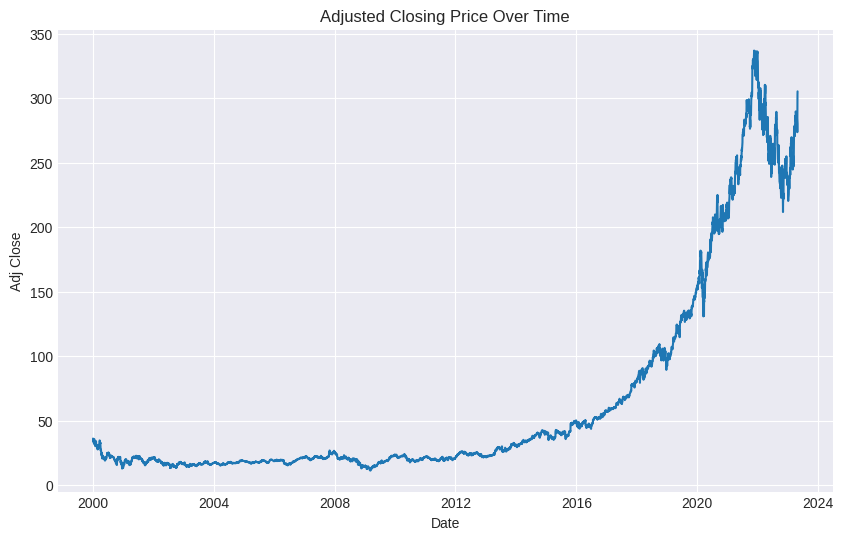

In [6]:
plt.plot(df.index, df['Adj Close'])
plt.title('Adjusted Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

# Prepare Data

In [7]:
def prepare_timeseries(df, window_size):
    df = df.copy()

    for i in reversed(range(1, window_size + 1)):
        df[f'Adj Close(t-{i})'] = df['Adj Close'].shift(i)

    df['Target'] = df['Adj Close']

    return df.dropna().drop("Adj Close", axis=1)

In [8]:
window_size = 5
dataset = prepare_timeseries(df, window_size)
dataset.head()

,Adj Close(t-5),Adj Close(t-4),Adj Close(t-3),Adj Close(t-2),Adj Close(t-1),Target
Date,,,,,,
2000-01-10,36.132259,34.911705,35.279808,34.097996,34.543606,34.795467
2000-01-11,34.911705,35.279808,34.097996,34.543606,34.795467,33.904266
2000-01-12,35.279808,34.097996,34.543606,34.795467,33.904266,32.799965
2000-01-13,34.097996,34.543606,34.795467,33.904266,32.799965,33.419922
2000-01-14,34.543606,34.795467,33.904266,32.799965,33.419922,34.795467


In [9]:
X = dataset.drop('Target', axis=1)
y = dataset[['Target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=False)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4983, 5), (880, 5), (4983, 1), (880, 1))

In [11]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# fit scalers
feature_scaler.fit(X_train)
target_scaler.fit(y_train)

MinMaxScaler()

### Create a PyTorch Dataset

In [12]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, feature_scaler, target_scaler):
        X = feature_scaler.transform(X)
        y = target_scaler.transform(y)
        self.X = torch.tensor(X[..., np.newaxis]).float()
        self.y = torch.tensor(y).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
batch_size = 32

# load in datasets
train_ds = TimeSeriesDataset(X_train, y_train, feature_scaler, target_scaler)
val_ds = TimeSeriesDataset(X_test, y_test, feature_scaler, target_scaler)

# batch into dataloaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [14]:
print(f'Train Loader Size: {len(train_loader)} \nValid Loader Size: {len(val_loader)}')

Train Loader Size: 156 
Valid Loader Size: 28


In [15]:
for ex_in, ex_out in train_loader:
    print(ex_in.shape, ex_out.shape)
    break

torch.Size([32, 5, 1]) torch.Size([32, 1])


# Define Model

In [16]:
INPUT_SIZE = 1
HIDDEN_SIZE = 64
OUTPUT_SIZE = 1
NUM_LAYERS = 2
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Create Early Stopper

In [18]:
class EarlyStopping:
    """
    Early stopping utility for monitoring validation loss during training.

    Args:
        patience (int): Number of epochs with no improvement after which training will be stopped.
        min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        restore_best_weights (bool): Whether to restore the model to the best state when stopping.

    Attributes:
        patience (int): Number of epochs with no improvement after which training will be stopped.
        min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        restore_best_weights (bool): Whether to restore the model to the best state when stopping.
        best_model: Copy of the model with the best validation loss.
        best_loss (float): Best validation loss observed so far.
        counter (int): Counter for the number of epochs with no improvement.
        status (str): Current status message indicating the early stopping progress.
    """

    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        """
        Check whether to stop training based on the validation loss.

        Args:
            model: The deep learning model being monitored.
            val_loss (float): Current validation loss.

        Returns:
            bool: True if training should be stopped, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model.state_dict())
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

# Create Trainer

In [19]:
class Trainer:
    """
    A class for training and evaluating a deep learning model.

    Args:
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        criterion: Loss criterion for training.
        optimizer: Optimizer for updating model parameters.
        model: The deep learning model to train and evaluate.
        device: Device on which to perform computations (e.g., 'cuda' or 'cpu').
        max_epochs (int): Maximum number of training epochs.

    Attributes:
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        criterion: Loss criterion for training.
        optimizer: Optimizer for updating model parameters.
        model: The deep learning model being trained and evaluated.
        device: Device on which computations are performed.
        early_stopper: Early stopping utility to monitor validation loss.
        max_epochs (int): Maximum number of training epochs.
        history (dict): Training and validation loss history.
        output_dir (str): Directory to save trained models.
    """

    def __init__(self,
                 train_loader,
                 val_loader,
                 criterion,
                 optimizer,
                 model,
                 device,
                 max_epochs):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.model = model
        self.device = device
        self.early_stopper = EarlyStopping(patience=10)
        self.max_epochs = max_epochs
        self.history = {}

    def _train_epoch(self):
        """
        Perform a single training epoch.

        Returns:
            float: Average training loss for the epoch.
        """
        self.model.train()
        running_loss = 0.00
        for batch_idx, (input, truth) in enumerate(self.train_loader):
            input, truth = input.to(self.device), truth.to(self.device)
            self.optimizer.zero_grad()
            pred = self.model(input)
            loss = self.criterion(pred, truth)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

        return running_loss / len(self.train_loader)

    @torch.no_grad()
    def _eval_epoch(self):
        """
        Perform a single evaluation epoch.

        Returns:
            float: Average validation loss for the epoch.
        """
        self.model.eval()
        running_loss = 0.00
        for batch_idx, (input, truth) in enumerate(self.val_loader):
            input, truth = input.to(self.device), truth.to(self.device)
            pred = self.model(input)
            loss = self.criterion(pred, truth)
            running_loss += loss.item()
        return running_loss / len(self.val_loader)

    def train(self):
        """
        Train the model using the provided training and validation data.

        This method trains the model for the specified number of epochs,
        monitoring training and validation loss, and applying early stopping.
        """
        best_val_loss = np.inf
        best_epoch = 0

        train_losses, val_losses = [], []
        for epoch in range(self.max_epochs):
            tloss = self._train_epoch()
            train_losses.append(tloss)

            vloss = self._eval_epoch()
            val_losses.append(vloss)

            if (epoch + 1 == 1) or ((epoch + 1) % 5 == 0):
                print(f'Epoch {epoch+1}/{self.max_epochs}:')
                print(f'Train loss: {tloss:.4f}')
                print(f'Val loss: {vloss:.4f}')
                print()

            if vloss < best_val_loss:
                best_val_loss = vloss
                best_epoch = epoch + 1

            if self.early_stopper(self.model, vloss):
                print(f'best epoch: {best_epoch}')
                break

        print('Training Finished')

        self.history = {'train': train_losses, 'val': val_losses}

    def evaluate(self):
        """
        Evaluate the trained model on the validation dataset.

        Returns:
            float: Rounded validation loss.
        """
        vloss = self._eval_epoch()
        return np.round(vloss, 4)

# Train Model

In [20]:
model = LSTM(
    INPUT_SIZE,
    HIDDEN_SIZE,
    OUTPUT_SIZE,
    NUM_LAYERS
).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6, weight_decay=0.01)

In [21]:
print(model)

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [22]:
with torch.no_grad():
    print(model(ex_in.to(DEVICE)).shape)

torch.Size([32, 1])


In [23]:
trainer = Trainer(
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    model=model,
    device=DEVICE,
    max_epochs=300
)

trainer.train()

Epoch 1/300:
Train loss: 0.1228
Val loss: 3.7545

Epoch 5/300:
Train loss: 0.1081
Val loss: 3.6467

Epoch 10/300:
Train loss: 0.0916
Val loss: 3.5099

Epoch 15/300:
Train loss: 0.0771
Val loss: 3.3645

Epoch 20/300:
Train loss: 0.0646
Val loss: 3.2090

Epoch 25/300:
Train loss: 0.0549
Val loss: 3.0467

Epoch 30/300:
Train loss: 0.0482
Val loss: 2.8838

Epoch 35/300:
Train loss: 0.0444
Val loss: 2.7327

Epoch 40/300:
Train loss: 0.0424
Val loss: 2.6072

Epoch 45/300:
Train loss: 0.0411
Val loss: 2.5072

Epoch 50/300:
Train loss: 0.0399
Val loss: 2.4175

Epoch 55/300:
Train loss: 0.0386
Val loss: 2.3265

Epoch 60/300:
Train loss: 0.0371
Val loss: 2.2265

Epoch 65/300:
Train loss: 0.0355
Val loss: 2.1200

Epoch 70/300:
Train loss: 0.0337
Val loss: 1.9993

Epoch 75/300:
Train loss: 0.0317
Val loss: 1.8692

Epoch 80/300:
Train loss: 0.0296
Val loss: 1.7226

Epoch 85/300:
Train loss: 0.0272
Val loss: 1.5561

Epoch 90/300:
Train loss: 0.0246
Val loss: 1.3767

Epoch 95/300:
Train loss: 0.0217


# Evaluate Training

In [24]:
trainer.evaluate()

0.0043

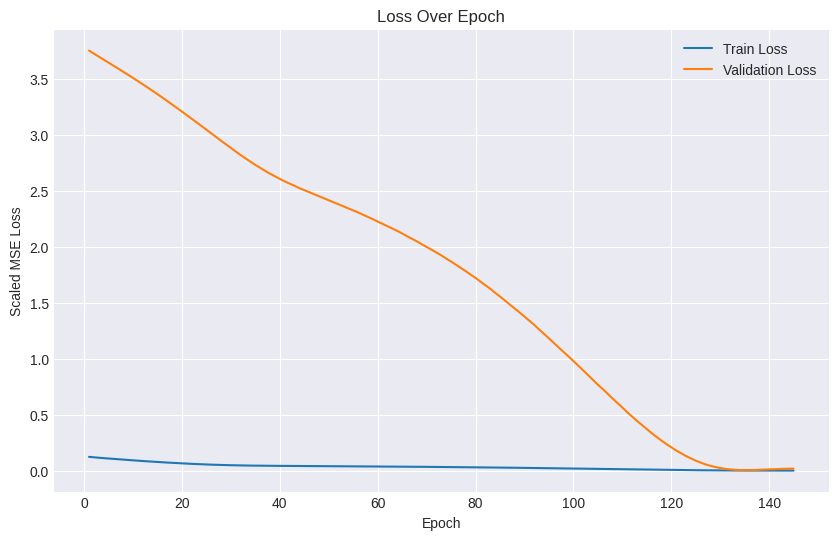

In [25]:
history = trainer.history
epochs = range(1, len(history['train']) + 1)
plt.plot(epochs, history['train'], label='Train Loss')
plt.plot(epochs, history['val'], label='Validation Loss')
plt.title('Loss Over Epoch')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Scaled MSE Loss')
plt.show()

# Visualize Forecast on Validation Data

In [26]:
torch_to_numpy = lambda x: x.flatten().detach().cpu().numpy()

In [27]:
preds = []
truths = []
with torch.no_grad():
    for in_data, out_data in val_ds:
        # Add inputs to device
        in_data = in_data.to(DEVICE)

        # Forward call
        output = model(in_data.unsqueeze(0))

        truth = torch_to_numpy(out_data)
        pred = torch_to_numpy(output)

        # Append data
        truths.append(target_scaler.inverse_transform(truth[..., np.newaxis]))
        preds.append(target_scaler.inverse_transform(pred[..., np.newaxis]))

truths, preds = [np.array(x).flatten() for x in (truths, preds)]

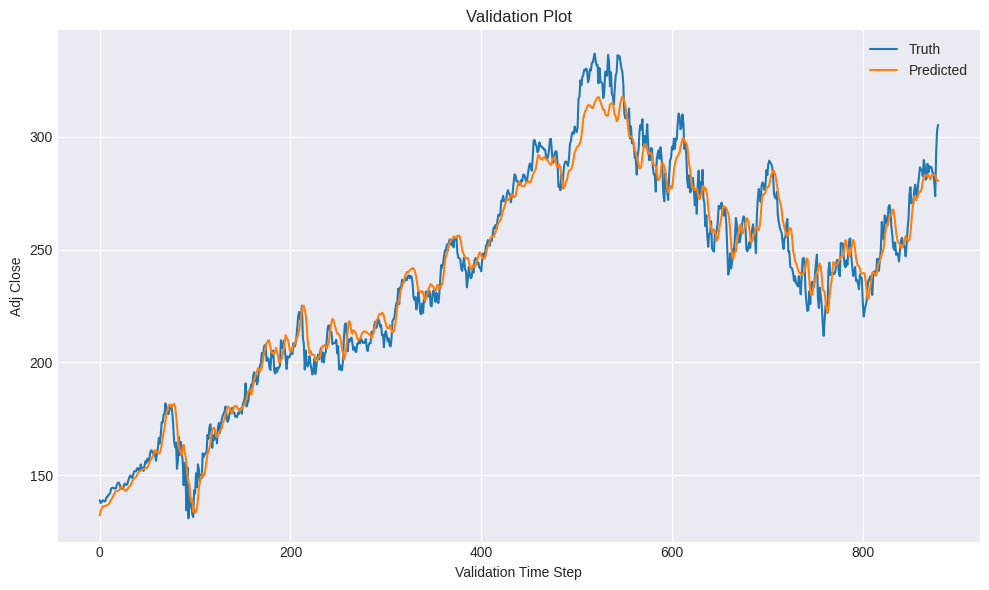

In [28]:
plt.plot(truths, label="Truth")
plt.plot(preds, label="Predicted")
plt.legend()
plt.ylabel("Adj Close")
plt.xlabel("Validation Time Step")
plt.title("Validation Plot")
plt.tight_layout()
plt.show()

# Create a Regression Report

In [29]:
def regression_report(y_true, y_pred):
    """
    Function to return a dictionary containing MAE, r2_score, MSE, and RMSE.
    """
    keys = ["MAE", "r2_score", "MSE"]
    functions = [mean_absolute_error, r2_score, mean_squared_error]
    metrics = {k: v(y_true, y_pred) for k, v in zip(keys, functions)}
    metrics["RMSE"] = np.sqrt(metrics["MSE"])
    return metrics

In [30]:
regression_report(truths, preds)

{'MAE': 6.3768826,
 'r2_score': 0.9718862384957592,
 'MSE': 69.36778,
 'RMSE': 8.3287325}